In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

Test of basic API endpoint from pre-set database view

In [ ]:
# Fetch data from API
url = "http://127.0.0.1:8001/EITI_Database/Project_production_by_commodity.json"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
columns = ['project_commodities', 'year', 'total_production_volume', 'project_unit']
df = pd.DataFrame(data['rows'], columns=columns)

# Convert year to int for proper plotting
df['year'] = df['year'].astype(int)

# Convert total_production_volume to a common unit (tonnes)
conversion_factors = {'grams': 1e-6, 'barrels': 0.159, 'tonnes': 1}
df['total_production_volume_tonnes'] = df.apply(lambda x: x['total_production_volume'] * conversion_factors[x['project_unit']], axis=1)

# Split and explode the project_commodities column
df['project_commodities'] = df['project_commodities'].str.split(', ')
df = df.explode('project_commodities')

# Group by commodities, year, and sum the total_production_volume_tonnes
grouped = df.groupby(['project_commodities', 'year'])['total_production_volume_tonnes'].sum().reset_index()

# Apply the fivethirtyeight style
plt.style.use('fivethirtyeight')

# Create small multiple plot
g = sns.FacetGrid(grouped, col="project_commodities", col_wrap=3, height=4, aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="year", y="total_production_volume_tonnes", marker='o', linewidth=2.5, markersize=8)

# Add titles and labels
g.set_axis_labels("Year", "Total Production\nVolume (tonnes)")
g.set_titles("Commodity: {col_name}")

# Set x-ticks to integer years
g.set(xticks=grouped['year'].unique())

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Reduce the number of y-axis ticks
for ax in g.axes.flat:
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.grid(False)  # Remove grid
    # Add red see-through vertical overlay between 2018 and 2019
    ax.axvspan(2018, 2019, color='red', alpha=0.1)

# Show plot
plt.show()

Test for interactive graphs using a API endpoint from a filtered table

Test of datasette's custom API endpoint

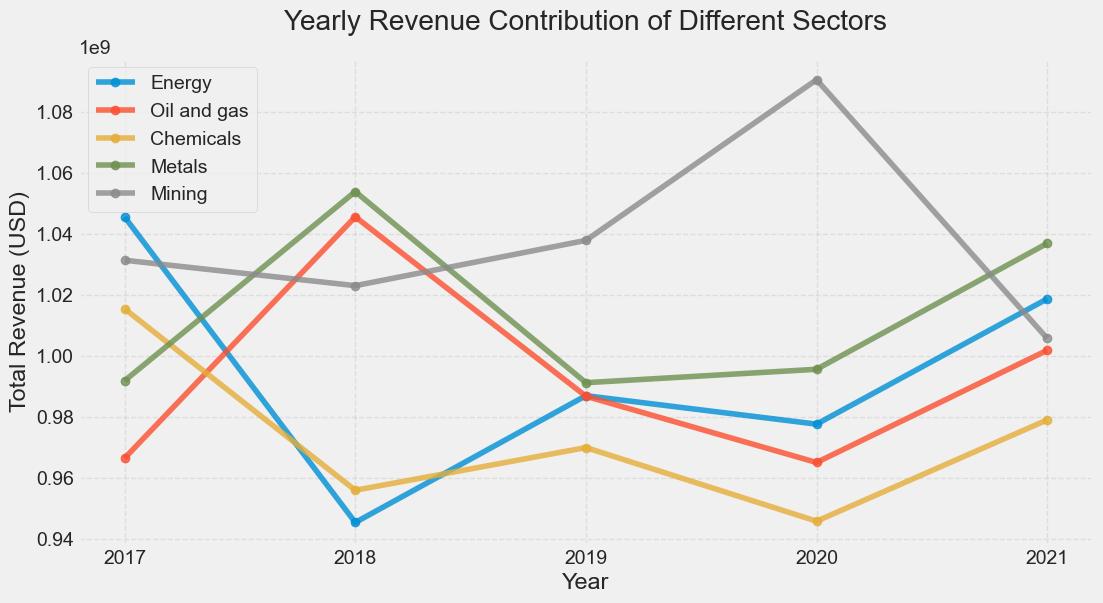

In [14]:
# Query the API endpoint
url = "http://127.0.0.1:8001/EITI_Database.json?sql=SELECT%0D%0A++++sector%2C%0D%0A++++year%2C%0D%0A++++SUM%28revenues_USD%29+AS+total_revenue%0D%0AFROM%0D%0A++++revenue%0D%0AJOIN%0D%0A++++companies+ON+revenue.company_id+%3D+companies.id%0D%0AGROUP+BY%0D%0A++++sector%2C+year%0D%0AORDER+BY%0D%0A++++sector%2C+year%3B"
response = requests.get(url)
data = response.json()

# Process the JSON data
sectors = list(set(row[0] for row in data['rows']))
years = sorted(list(set(row[1] for row in data['rows'])))
revenues_by_sector = {sector: [] for sector in sectors}

for year in years:
    for sector in sectors:
        total_revenue = 0
        for row in data['rows']:
            if row[0] == sector and row[1] == year:
                total_revenue = row[2]
                break
        revenues_by_sector[sector].append(total_revenue)

# Create a line chart with multiple lines
fig, ax = plt.subplots(figsize=(12, 7))

for sector, revenues in revenues_by_sector.items():
    ax.plot(years, revenues, label=sector, alpha=0.8, marker='o')

ax.legend(loc='upper left')
ax.set_title('Yearly Revenue Contribution of Different Sectors', pad=20)
ax.set_xlabel('Year')
ax.set_ylabel('Total Revenue (USD)')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout(pad=3.0)
plt.show()


In [15]:
import requests
import plotly.graph_objects as go

# Query the API endpoint
url = "http://127.0.0.1:8001/EITI_Database.json?sql=SELECT%0D%0A++++sector%2C%0D%0A++++year%2C%0D%0A++++SUM%28revenues_USD%29+AS+total_revenue%0D%0AFROM%0D%0A++++revenue%0D%0AJOIN%0D%0A++++companies+ON+revenue.company_id+%3D+companies.id%0D%0AGROUP+BY%0D%0A++++sector%2C+year%0D%0AORDER+BY%0D%0A++++sector%2C+year%3B"
response = requests.get(url)
data = response.json()

# Process the JSON data
sectors = list(set(row[0] for row in data['rows']))
years = sorted(list(set(row[1] for row in data['rows'])))
revenues_by_sector = {sector: [] for sector in sectors}

for year in years:
    for sector in sectors:
        total_revenue = 0
        for row in data['rows']:
            if row[0] == sector and row[1] == year:
                total_revenue = round(row[2], 2)  # Rounding the numbers
                break
        revenues_by_sector[sector].append(total_revenue)

# Create an interactive line chart using Plotly
fig = go.Figure()

for sector, revenues in revenues_by_sector.items():
    hover_text = [f"<b>{sector}</b><br>Year: {year}<br>Total Revenue: ${revenue:,.2f}" for year, revenue in zip(years, revenues)]
    fig.add_trace(go.Scatter(
        x=years, y=revenues, mode='lines+markers', name=sector,
        hovertemplate='<br>'.join(hover_text) + '<extra></extra>'
    ))

fig.update_layout(
    title='Yearly Revenue Contribution of Different Sectors',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total Revenue (USD)'),
    hovermode='x'
)

fig.show()
